## Time Series Project

In [18]:
import numpy as np
import pandas as pd
import os 
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename)) 

In [19]:
import matplotlib.pyplot as plt  # plots
import numpy as np  # vectors and matrices
import pandas as pd  # tables and data manipulations
import seaborn as sns  # more plots

sns.set()

import warnings  
from itertools import product  # some useful functions

import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.formula.api as smf  # statistics and econometrics
import statsmodels.tsa.api as smt
from dateutil.relativedelta import \
    relativedelta  # working with dates with style
from scipy.optimize import minimize  # for function minimization
from tqdm.notebook import tqdm

warnings.filterwarnings("ignore") # `do not disturbe` mode

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


In [20]:
df = pd.read_csv('dataset.txt')

df.head()

,date,value
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869


In [21]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df.value.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 3.145186
p-value: 1.000000


Since p-value(1.00) is greater than the significance level(0.05), let’s difference the series and see how the autocorrelation plot looks like.

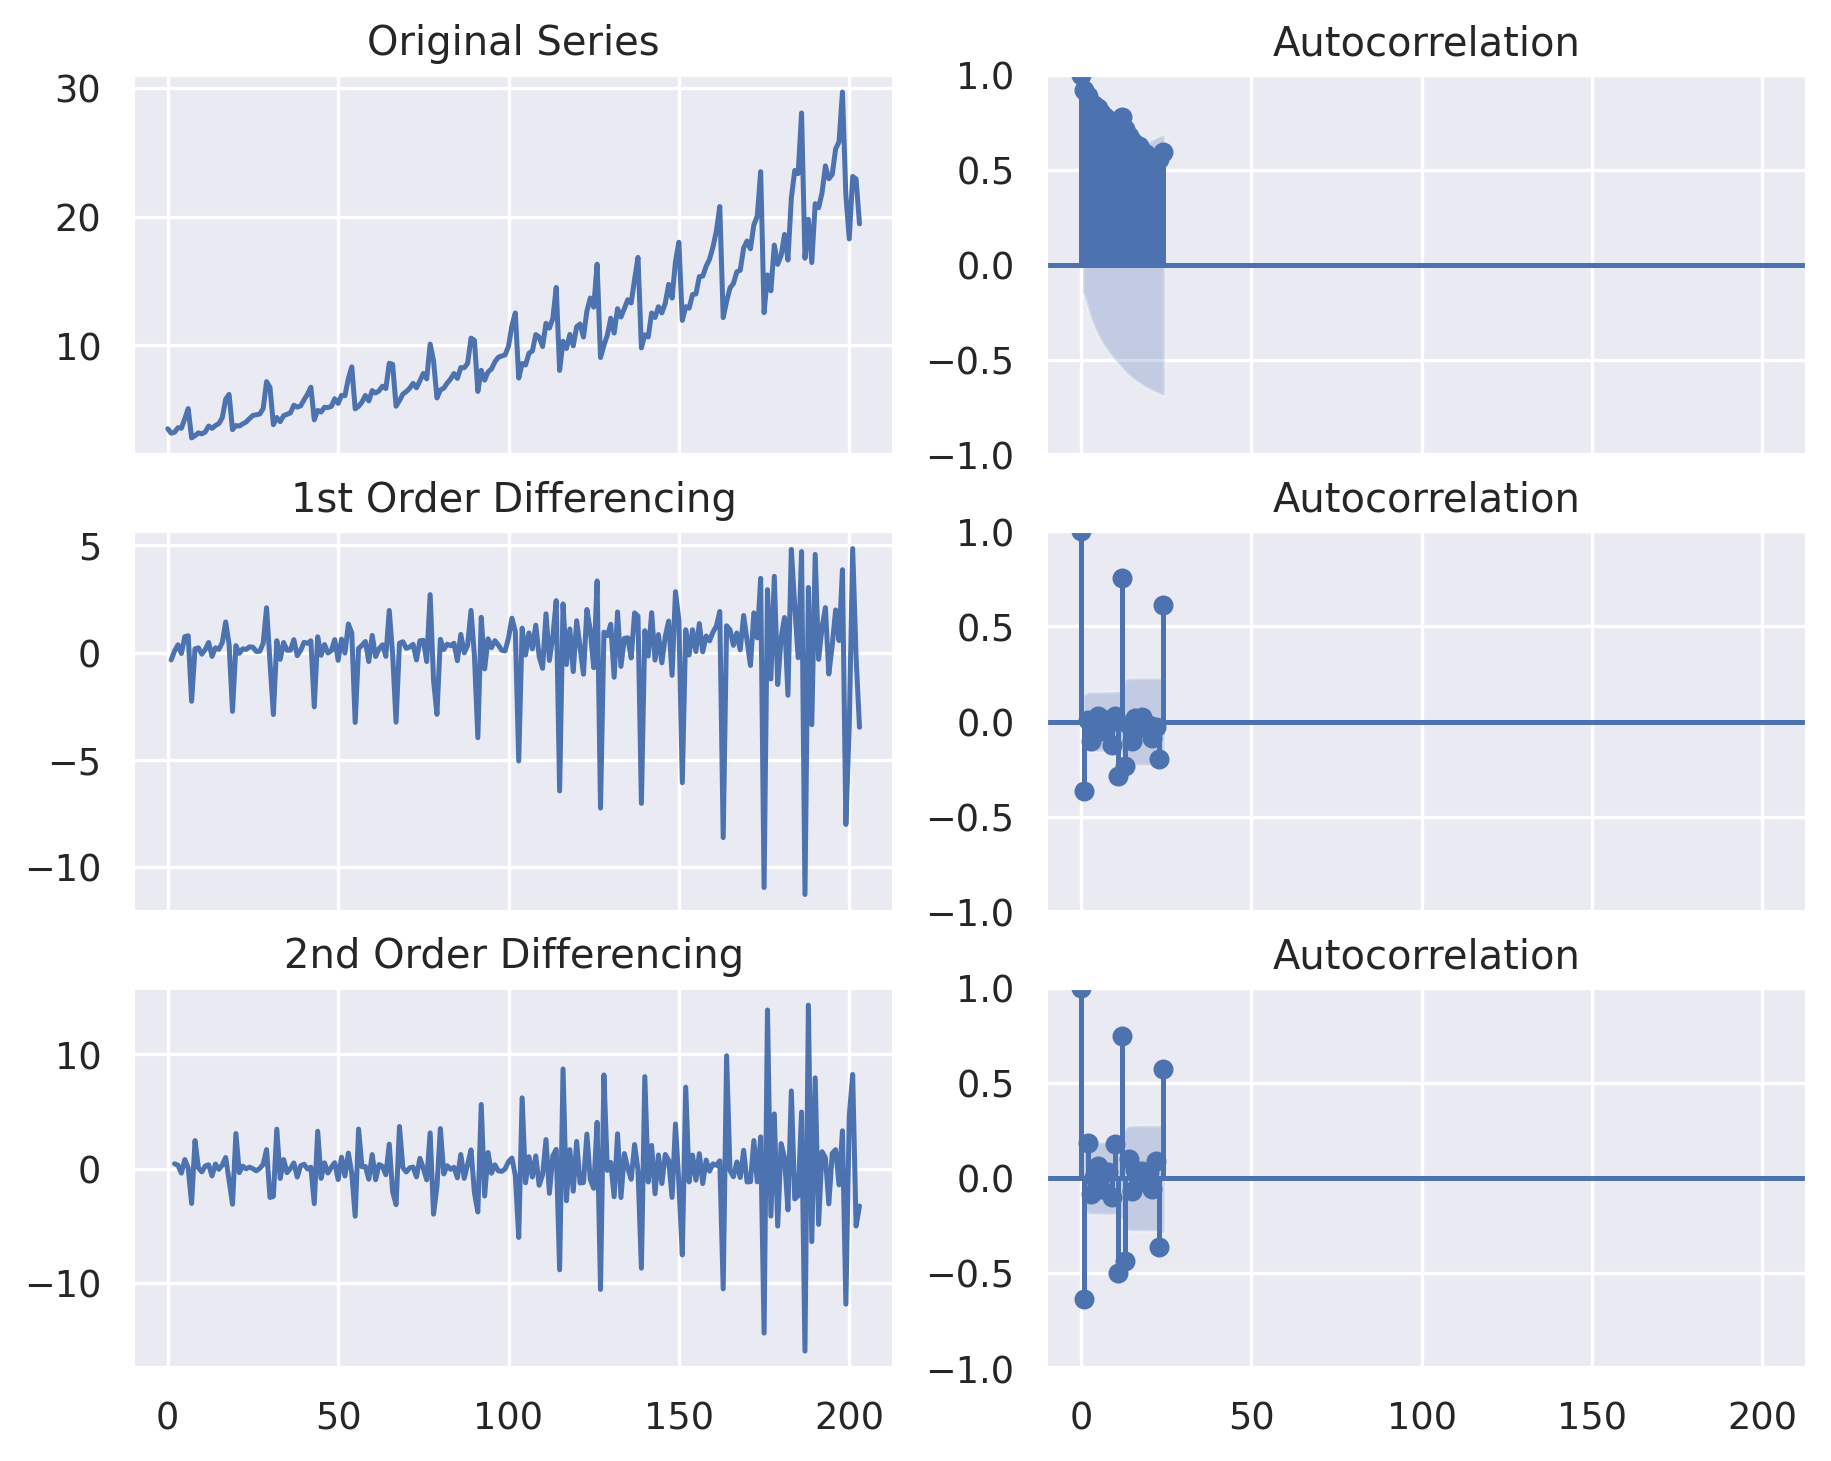

In [22]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})


# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.value); axes[0, 0].set_title('Original Series')
plot_acf(df.value, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.value.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.value.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.value.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.value.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

## How to find the order of the AR term (p)

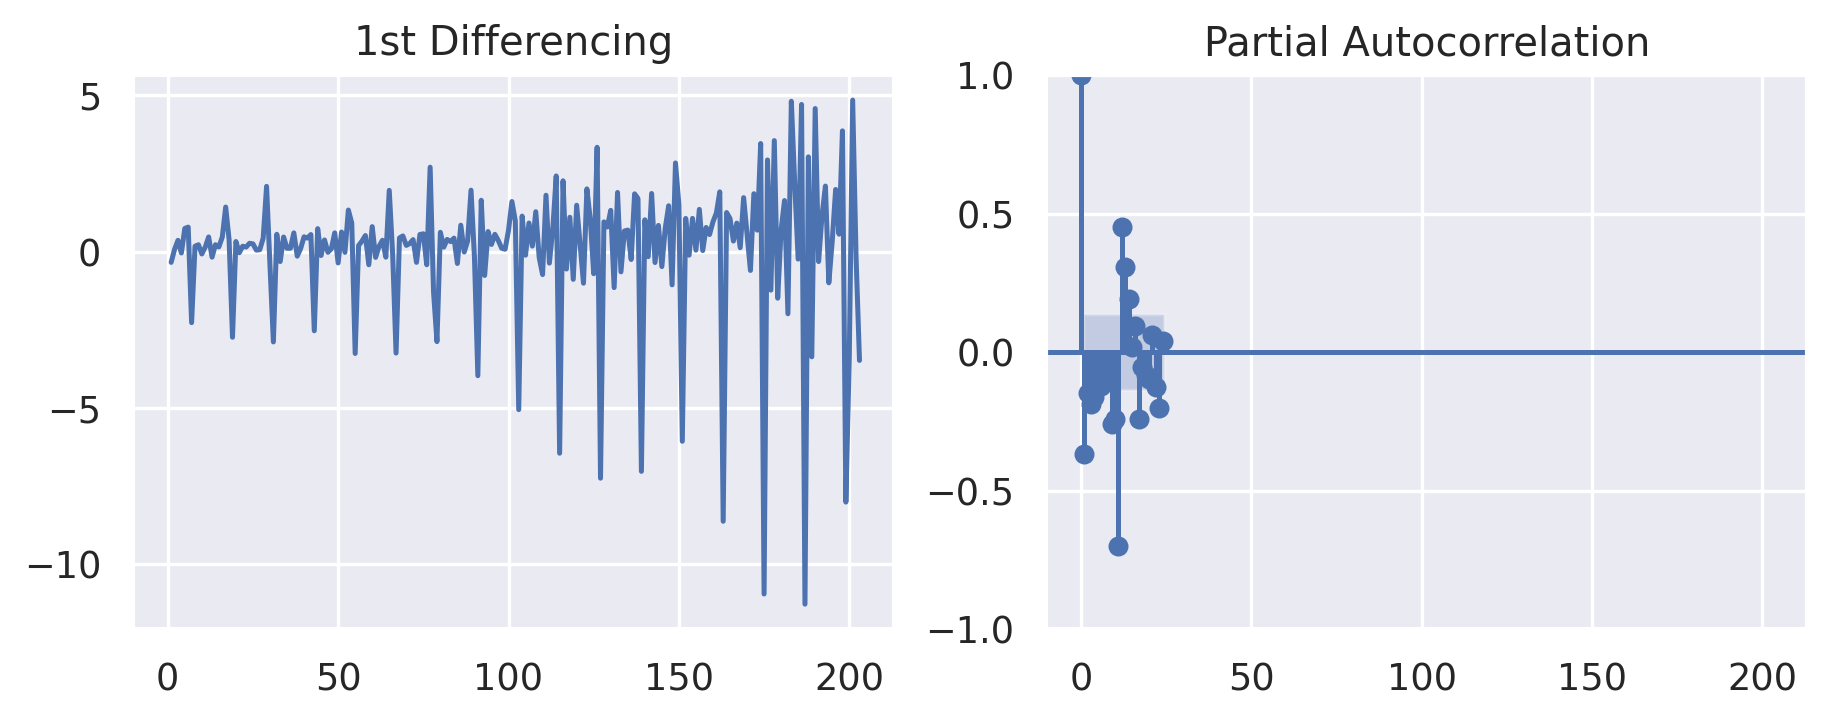

In [23]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.value.diff().dropna(), ax=axes[1])

plt.show()

## 7. How to find the order of the MA term (q)

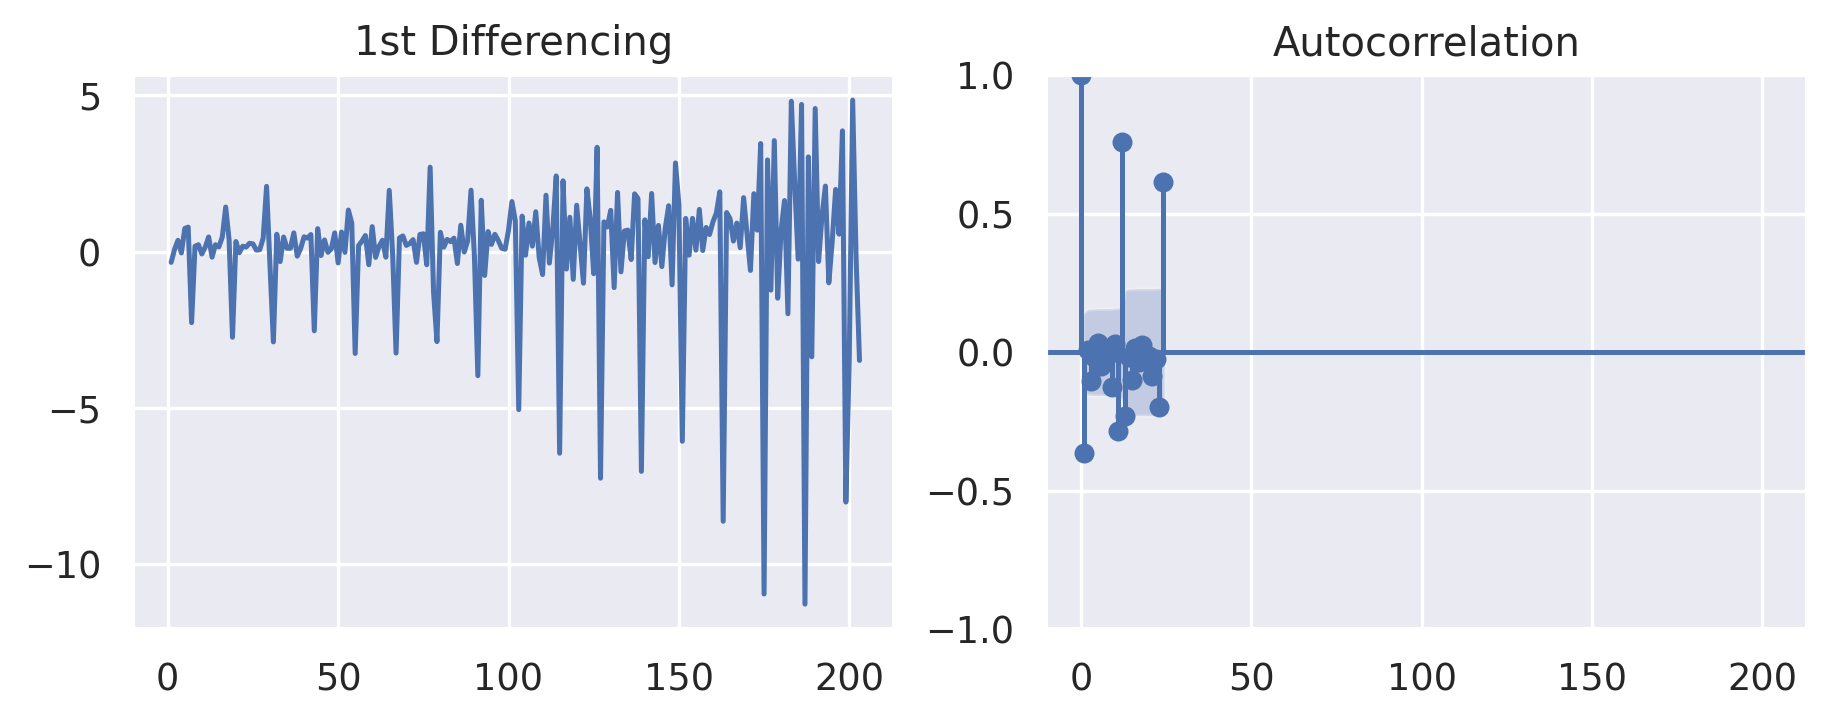

In [24]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df.value.diff().dropna(), ax=axes[1])

plt.show()

## 8. How to handle if a time series is slightly under or over differenced 

## 9. How to build the ARIMA Model

Now, we have determined the values of p, d and q. We have everything needed to fit the ARIMA model. We will use the ARIMA() implementation in the statsmodels package.

In [25]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

In [49]:
# Instantiate ARIMA model
model = sm.tsa.ARIMA(df.value, order=(1, 1, 2))

# Fit the model to the data
results = model.fit()

# Print model summary
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  204
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -424.570
Date:                Mon, 13 Mar 2023   AIC                            857.140
Time:                        11:33:18   BIC                            870.393
Sample:                             0   HQIC                           862.502
                                - 204                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4178      0.356      1.174      0.240      -0.280       1.115
ma.L1         -0.9546      0.377     -2.531      0.011      -1.694      -0.215
ma.L2          0.0969      0.272      0.356      0.7



    The model summary provides lot of information. The table in the middle is the coefficients table where the values under ‘coef’ are the weights of the respective terms.

    The coefficient of the MA2 term is close to zero and the P-Value in ‘P>|z|’ column is highly insignificant. It should ideally be less than 0.05 for the respective X to be significant.

    So, we will rebuild the model without the MA2 term.



In [50]:
# Instantiate ARIMA model
model = sm.tsa.ARIMA(df.value, order=(1, 1, 1))

# Fit the model to the data
results = model.fit()

# Print model summary
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  204
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -424.762
Date:                Mon, 13 Mar 2023   AIC                            855.524
Time:                        11:33:19   BIC                            865.463
Sample:                             0   HQIC                           859.545
                                - 204                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3009      0.094      3.195      0.001       0.116       0.485
ma.L1         -0.8300      0.048    -17.204      0.000      -0.925      -0.735
sigma2         3.8327      0.259     14.790      0.0



    The model AIC has slightly reduced, which is good. The p-values of the AR1 and MA1 terms have improved and are highly significant (<< 0.05).

    Let’s plot the residuals to ensure there are no patterns (that is, look for constant mean and variance).



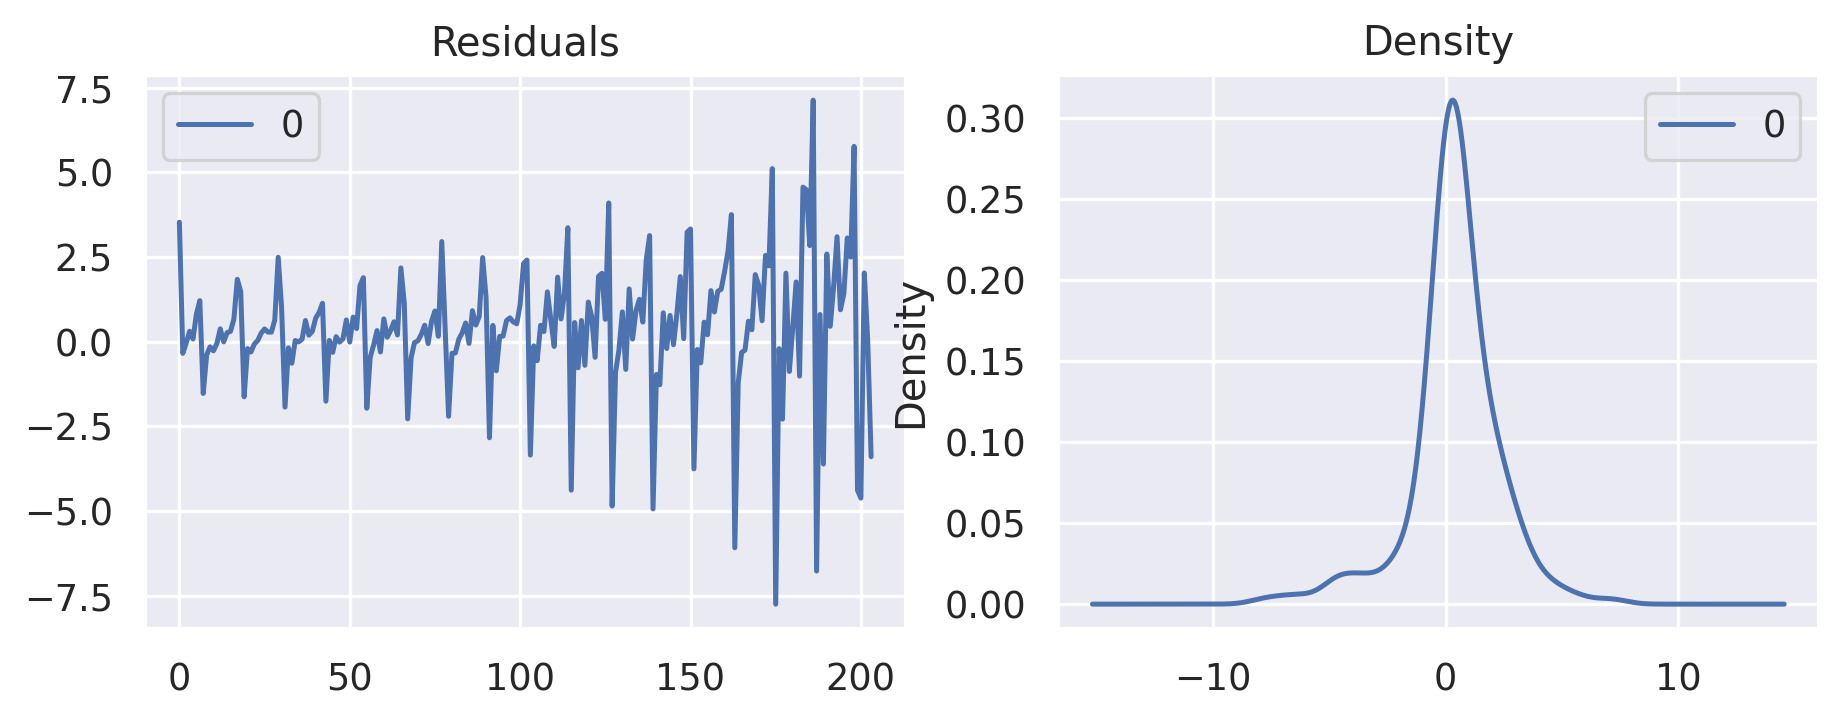

In [51]:
# Plot residual errors
residuals = pd.DataFrame(results.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

The residual errors seem fine with near zero mean and uniform variance. Let’s plot the actuals against the fitted values using plot_predict().

In [52]:
!pip install plot_predict

ERROR: Could not find a version that satisfies the requirement plot_predict (from versions: none)
ERROR: No matching distribution found for plot_predict


In [47]:
# Actual vs Fitted
results.plot_predict(dynamic=False)
plt.show()

AttributeError: 'ARIMAResults' object has no attribute 'plot_predict'

AttributeError: 'PredictionResults' object has no attribute 'results'

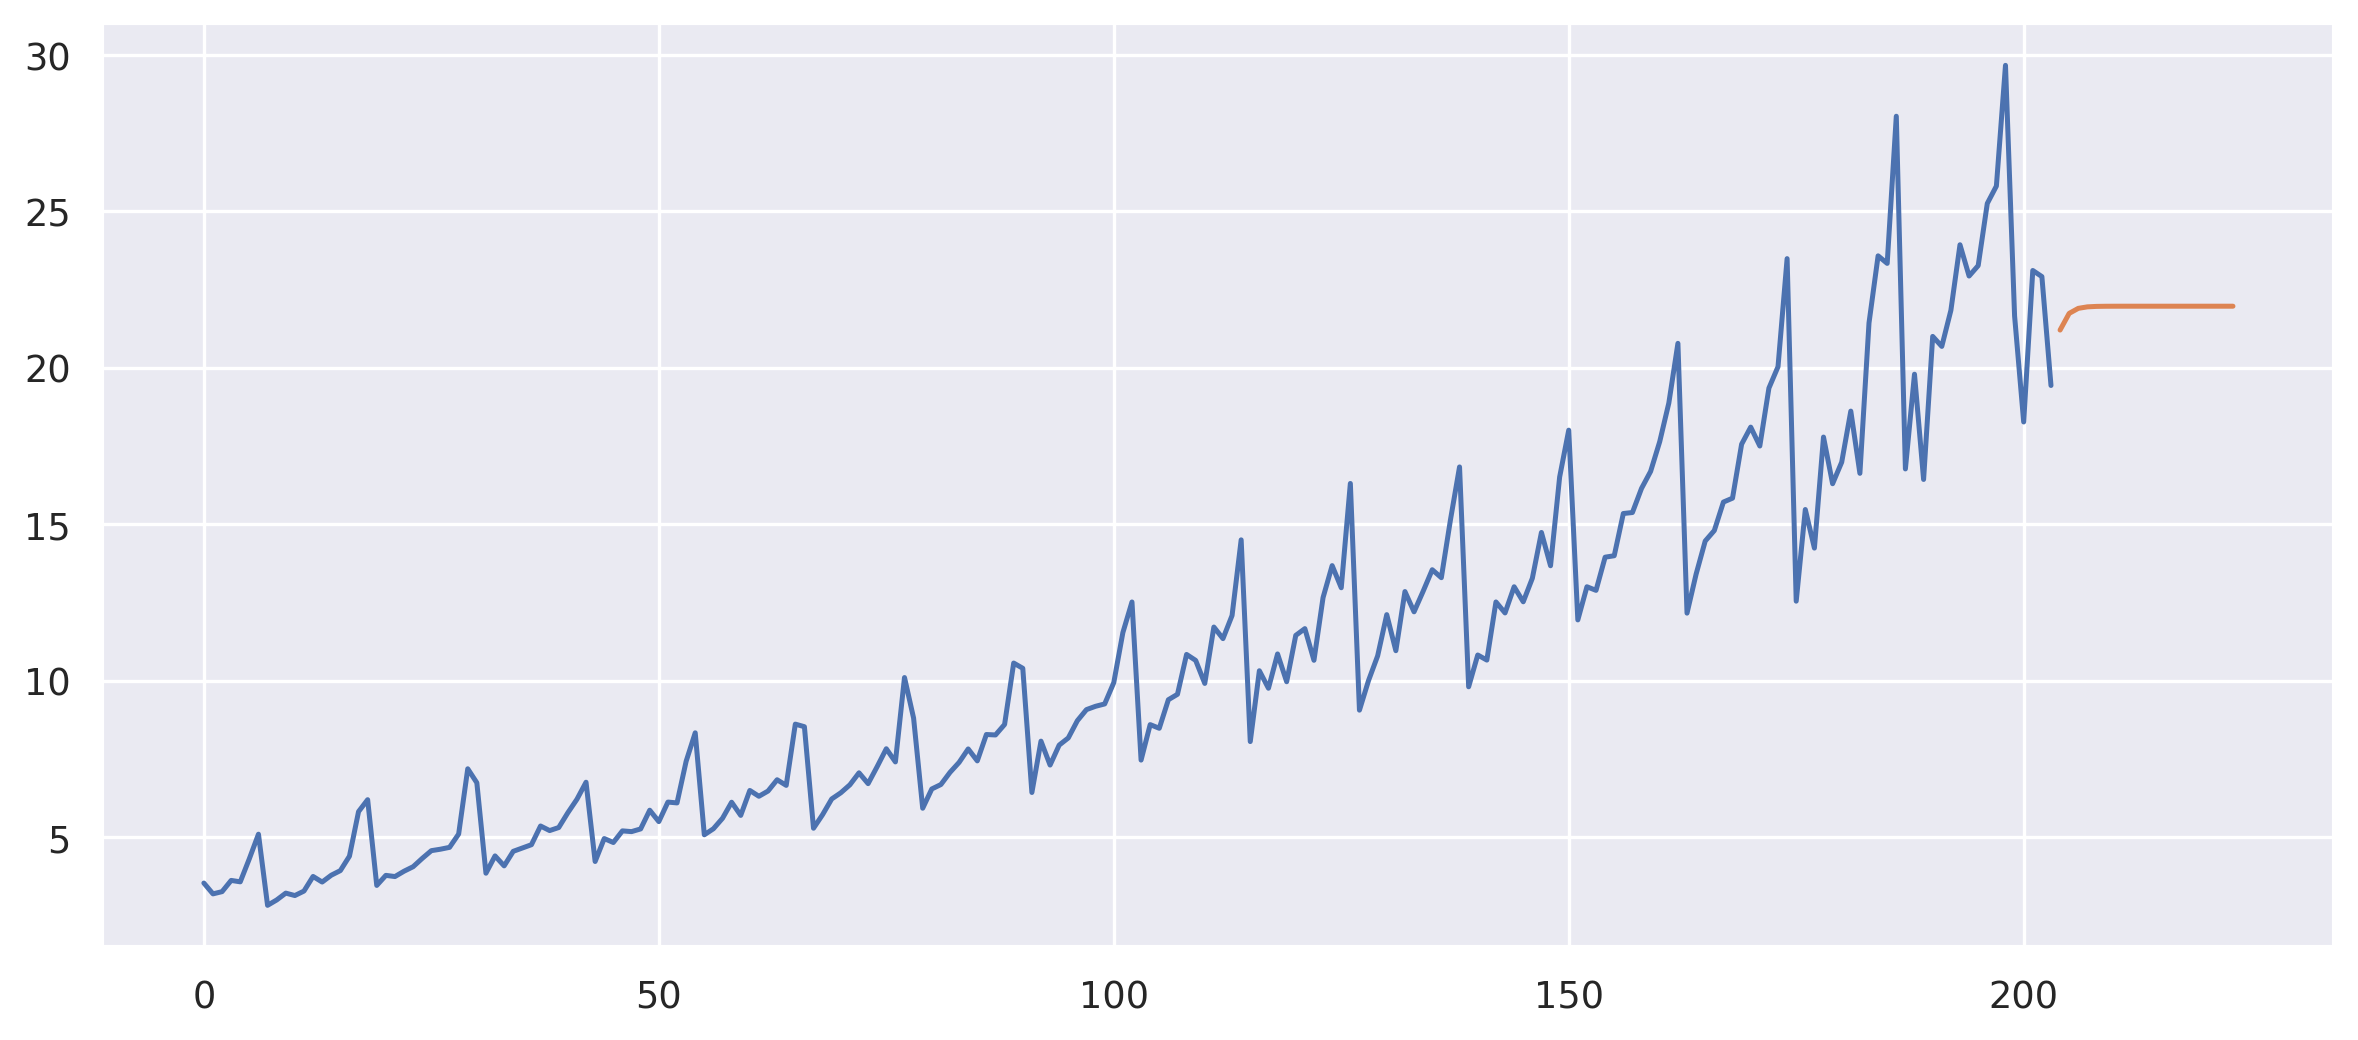

In [57]:
forecast = results.get_forecast(steps=20)

# plot the predicted values with confidence interval
plt.figure(figsize=(12,5))
plt.plot(df.value, label='Observed')
plt.plot(forecast.predicted_mean, label='Forecast')
plt.fill_between(forecast.results, 
                 forecast.conf_int()['lower Value'], 
                 forecast.conf_int()['upper Value'], color='grey', alpha=0.2)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('ARIMA Model Prediction')
plt.legend()
plt.show()

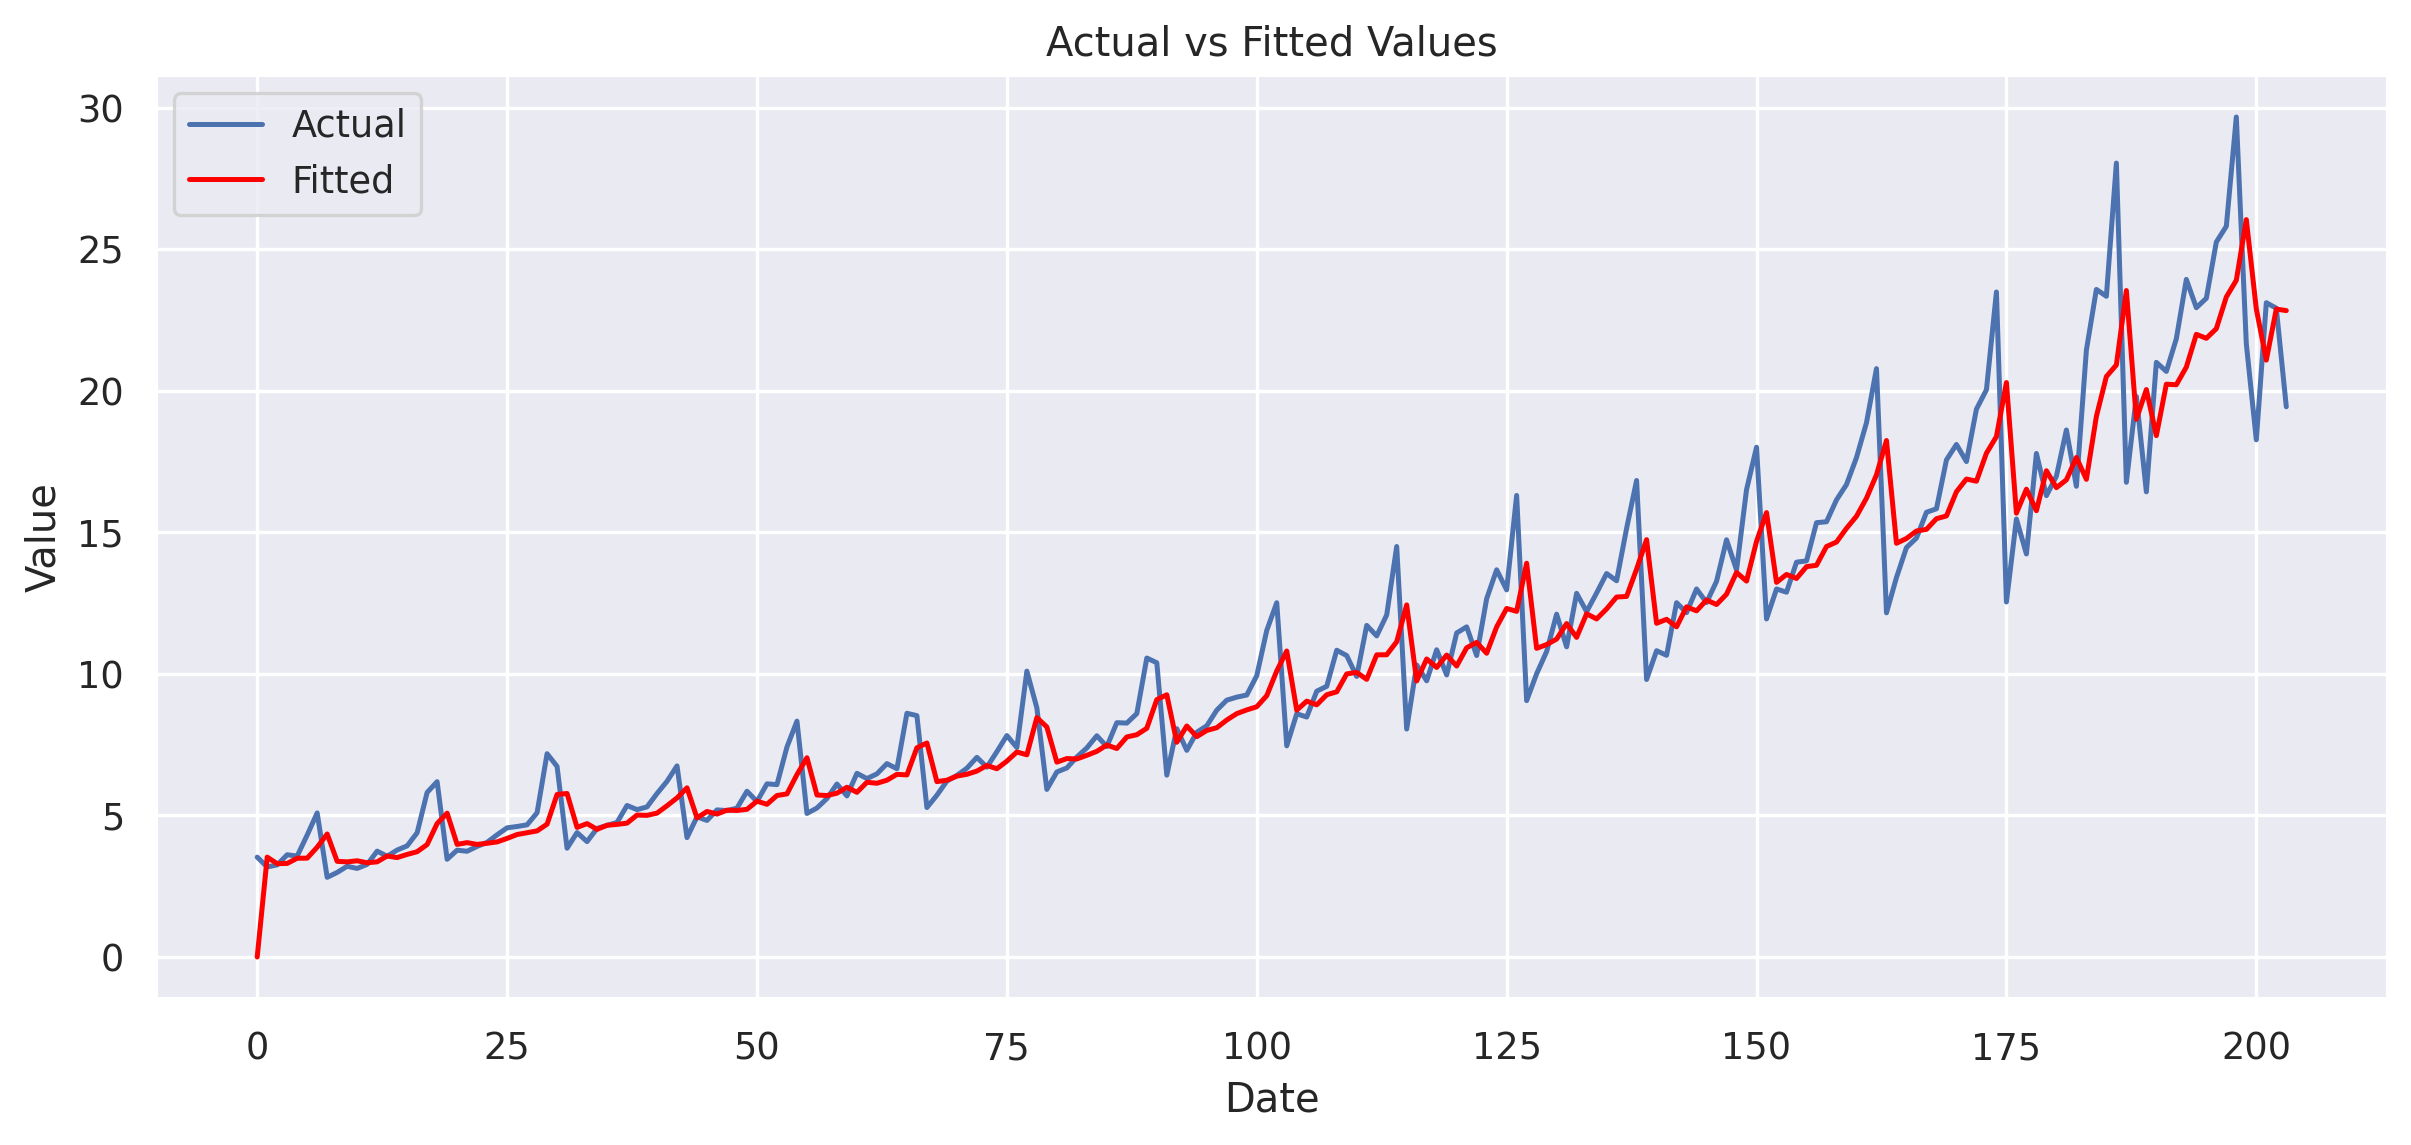

In [55]:
# get the fitted values
fitted_values = results.fittedvalues

# plot actual vs fitted values
plt.figure(figsize=(12,5))
plt.plot(df.value, label='Actual')
plt.plot(fitted_values, color='red', label='Fitted')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Fitted Values')
plt.legend()
plt.show()
